In [11]:
import sys
import os
import numpy as np

# Ensure the Reinforcemente_Learning directory is in the Python path
# (May not be necessary if running from the directory containing RL folder)
# sys.path.insert(0, os.path.abspath(os.path.dirname(__file__)))

try:
    import data_preparation
    import environment
    import model_training
    import evaluation
    import inference
except ImportError as e:
    print(f"Error importing modules: {e}")
    print("Please ensure all required files (data_preparation.py, environment.py, model_training.py, evaluation.py, inference.py) exist in the same directory.")
    sys.exit(1)

# --- Configuration ---
# Set these to True/False to control which phases run
RUN_DATA_PREPARATION = True
RUN_OFFLINE_TRAINING = True
RUN_EVALUATION = True
RUN_INTERACTIVE_PLAY = True # Renamed from RUN_INFERENCE_DEMO

# --- Parameters ---
# Assuming notebook runs from Reinforcemente_Learning directory
DATA_FILE = data_preparation.DATA_FILE # Get from data_preparation module
OFFLINE_BUFFER_FILE = 'offline_replay_buffer.npz'
FINAL_MODEL_FILE = 'offline_trained_model.pth' # Model trained offline is the final model

OFFLINE_EPOCHS = 5000  # Adjust as needed for training
BATCH_SIZE = model_training.BATCH_SIZE # Get from model_training module
EVALUATION_EPISODES = 1000
TARGET_LIFT_TIER = 1 # Example: Train/Evaluate primarily for this tier
SEED = 42 # For reproducibility

# --- Initialization ---
offline_buffer = None
agent = None
model_to_eval = None
inference_module = None

print("--- Configuration Loaded ---")
print(f"Current working directory: {os.getcwd()}")

--- Configuration Loaded ---
Current working directory: c:\Users\gpnc_\OneDrive\Documentos\GitHub\Retail_Mardown_Game\Reinforcemente_Learning


## Phase 1: Data Preparation

In [13]:
# === Phase 1: Data Preparation ===
if RUN_DATA_PREPARATION:
    print("\n--- Running Phase 1: Data Preparation ---")
    try:
        # Prepare data and get the buffer in memory
        # Assumes DATA_FILE is in the current directory
        offline_buffer = data_preparation.prepare_offline_data(data_path=DATA_FILE)

        # Save the buffer for potential reuse
        if offline_buffer:
            print(f"Saving offline buffer to {OFFLINE_BUFFER_FILE}...")
            # Save buffer in the same directory
            np.savez_compressed(OFFLINE_BUFFER_FILE, buffer=np.array(offline_buffer, dtype=object))
            print(f"Buffer with {len(offline_buffer)} experiences saved.")
        else:
            print("Warning: Offline buffer generation failed or returned empty.")
            raise Exception("Data preparation failed.") # Stop if no data

    except Exception as e:
        print(f"Error during Data Preparation: {e}")
        raise # Re-raise the exception to stop notebook execution
else:
    print("\n--- Skipping Phase 1: Data Preparation ---")
    # Try to load previously saved buffer if skipping prep and needed for training
    if RUN_OFFLINE_TRAINING or RUN_EVALUATION: # Load if needed for subsequent steps
        try:
            print(f"Loading offline buffer from {OFFLINE_BUFFER_FILE}...")
            loaded_data = np.load(OFFLINE_BUFFER_FILE, allow_pickle=True)
            offline_buffer = loaded_data['buffer'].tolist()
            print(f"Loaded {len(offline_buffer)} offline experiences.")
            if not offline_buffer:
                print("Error: Loaded offline buffer is empty.")
                raise Exception(f"{OFFLINE_BUFFER_FILE} is empty.")
        except FileNotFoundError:
            print(f"Error: {OFFLINE_BUFFER_FILE} not found. Cannot proceed without data preparation or existing buffer.")
            raise
        except Exception as e:
            print(f"Error loading offline buffer: {e}")
            raise


--- Running Phase 1: Data Preparation ---
Loading raw data from raw_data.csv...
Raw data loaded: 544000 rows.
Columns found: ['combo', 'replication', 'week', 'price', 'sales', 'remain_invent']
Parsing episodes and constructing RL tuples...
Processed 1000/34000 episodes. Buffer size: 14915
Processed 2000/34000 episodes. Buffer size: 29741
Processed 3000/34000 episodes. Buffer size: 44436
Processed 4000/34000 episodes. Buffer size: 59071
Processed 5000/34000 episodes. Buffer size: 73704
Processed 6000/34000 episodes. Buffer size: 87953
Processed 7000/34000 episodes. Buffer size: 102586
Processed 8000/34000 episodes. Buffer size: 116795
Processed 9000/34000 episodes. Buffer size: 131148
Processed 10000/34000 episodes. Buffer size: 145385
Processed 11000/34000 episodes. Buffer size: 159110
Processed 12000/34000 episodes. Buffer size: 173645
Processed 13000/34000 episodes. Buffer size: 187692
Processed 14000/34000 episodes. Buffer size: 201161
Processed 15000/34000 episodes. Buffer size: 2

## Phase 2 - Environment Info

In [14]:
# === Phase 2: Environment Design (Used in Eval/Interactive) ===
print("\n--- Phase 2: Environment Design ---")
print("Note: The environment class (RetailMarkdownEnv) will be instantiated")
print("      within the Evaluation and Interactive Play phases as needed.")
# Define state/action dimensions based on environment/data spec
# These should match how the data was prepared and how the env is defined
STATE_DIM = model_training.STATE_DIM # Get from module where it's defined
ACTION_DIM = model_training.ACTION_DIM # Get from module where it's defined
print(f"State Dimension: {STATE_DIM}, Action Dimension: {ACTION_DIM}")


--- Phase 2: Environment Design ---
Note: The environment class (RetailMarkdownEnv) will be instantiated
      within the Evaluation and Interactive Play phases as needed.
State Dimension: 4, Action Dimension: 4


## Phase 3 - Model Training (Offline CQL)

In [15]:
# === Phase 3: Model Training (Offline CQL) ===
if RUN_OFFLINE_TRAINING:
    print("\n--- Running Phase 3: Model Training (Offline CQL) ---")
    if offline_buffer is None:
         print("Error: Offline buffer not available for training. Make sure Cell 2 ran successfully or RUN_DATA_PREPARATION=False and buffer file exists.")
         raise Exception("Offline buffer is None.")

    # Initialize Agent
    print("Initializing RL Agent...")
    agent = model_training.RLAgent(
        state_size=STATE_DIM,
        action_size=ACTION_DIM,
        offline_buffer=offline_buffer, # Pass the loaded/generated offline buffer
        seed=SEED
    )

    # --- Offline Pretraining (Saves the final model) ---
    print(f"Starting Offline Pretraining (CQL) for {OFFLINE_EPOCHS} epochs...")
    try:
        agent.train_offline_cql(
            epochs=OFFLINE_EPOCHS,
            batch_size=BATCH_SIZE,
            model_save_path=FINAL_MODEL_FILE # Save directly to final path
        )
        print(f"Offline training complete. Model saved to {FINAL_MODEL_FILE}")
        # Clear buffer from memory if large and not needed anymore (agent keeps a reference internally for training)
        # del offline_buffer
        # import gc
        # gc.collect()
        # print("Offline buffer cleared from main scope memory.")
    except Exception as e:
        print(f"Error during Offline Training: {e}")
        raise
else:
    print("\n--- Skipping Phase 3: Model Training ---")
    if RUN_EVALUATION or RUN_INTERACTIVE_PLAY:
        print(f"Note: Evaluation/Interactive Play will attempt to load the model from {FINAL_MODEL_FILE}")



--- Running Phase 3: Model Training (Offline CQL) ---
Initializing RL Agent...
Agent initialized with 467130 offline experiences.
Starting Offline Pretraining (CQL) for 5000 epochs...
Starting CQL Offline Training for 5000 epochs (3649 batches per epoch)...
CQL Alpha: 5.0, Target Update Freq: 100, Batch Size: 128
Epoch 100/5000	Avg Loss: 23478933.9364	Q1 Loss: 23470369.3138	CQL Loss: 1712.9218
Epoch 200/5000	Avg Loss: 18783386.8868	Q1 Loss: 18779161.0951	CQL Loss: 845.1608
Epoch 300/5000	Avg Loss: 20703394.5185	Q1 Loss: 20699682.8700	CQL Loss: 742.3301


KeyboardInterrupt: 

## Phase 4 - Policy Evaluation

In [24]:
# === Phase 4: Policy Evaluation (Using Simulation Environment) ===
if RUN_EVALUATION:
    print("\n--- Running Phase 4: Policy Evaluation (Simulated) ---")
    try:
        # Create environment for evaluation
        print(f"Creating evaluation environment for Lift Tier: {TARGET_LIFT_TIER}")
        env_eval = environment.RetailMarkdownEnv(lift_tier=TARGET_LIFT_TIER) # Use different seed for eval env
        env_eval.seed(SEED + 1) # Set seed using the .seed() method

        # Load the final model (trained offline)
        print(f"Loading model for evaluation from: {FINAL_MODEL_FILE}")
        # Need to pass state/action dim to load_trained_model if the model class requires them
        model_to_eval = evaluation.load_trained_model(FINAL_MODEL_FILE, STATE_DIM, ACTION_DIM)

        rl_agent_results = None # Initialize
        if model_to_eval:
            print(f"Evaluating RL Agent Policy over {EVALUATION_EPISODES} episodes...")
            rl_agent_results = evaluation.evaluate_policy(
                env=env_eval,
                model=model_to_eval,
                n_episodes=EVALUATION_EPISODES,
                state_dim=STATE_DIM, # Pass state_dim if needed by evaluate_policy
                action_dim=ACTION_DIM # Pass action_dim if needed
            )
            print("RL Agent evaluation complete.")
        else:
            print(f"Skipping RL agent evaluation as model could not be loaded from {FINAL_MODEL_FILE}.")


        # Run benchmarks
        print("Running Benchmark Policies...")
        benchmark_policies_map = {
            "Linear Markdown": evaluation.linear_markdown_policy,
            "Rule-Based": evaluation.rule_based_policy,
            "Random Valid Actions": evaluation.random_policy
        }
        benchmark_results_list = []
        for i, (name, policy_func) in enumerate(benchmark_policies_map.items()):
            print(f"  Running Benchmark: {name}...")
            # Re-seed or reset env for each benchmark if desired for fairness
            # The initial seed for env_eval was SEED + 1.
            # For benchmarks, we use SEED + 1 + (i+1) to ensure different sequences if desired.
            # Or, more simply, SEED + 2 + i
            env_eval.seed(SEED + 2 + i) # Example re-seed, ensuring it's different from initial and other benchmarks
            results = evaluation.run_benchmark(
                env=env_eval,
                policy_func=policy_func,
                policy_name=name,
                n_episodes=EVALUATION_EPISODES
            )
            benchmark_results_list.append(results)
        print("Benchmark policies evaluation complete.")

        # Analyze and compare
        print("Analyzing and plotting results...")
        if rl_agent_results:
            evaluation.analyze_results(rl_agent_results, benchmark_results_list)
            plt.show() # Ensure plots are displayed in the notebook
        else:
             print("\nSkipping final comparison plots as RL agent results are unavailable.")

        env_eval.close()
        print("Evaluation environment closed.")

    except Exception as e:
        print(f"Error during Evaluation: {e}")
        raise
else:
    print("\n--- Skipping Phase 4: Policy Evaluation ---")



--- Running Phase 4: Policy Evaluation (Simulated) ---
Creating evaluation environment for Lift Tier: 1
Error during Evaluation: 'RetailMarkdownEnv' object has no attribute 'seed'


AttributeError: 'RetailMarkdownEnv' object has no attribute 'seed'

In [31]:
# === Phase 4: Policy Evaluation (Using Simulation Environment) ===
import matplotlib.pyplot as plt

if RUN_EVALUATION:
    print("\n--- Running Phase 4: Policy Evaluation (Simulated) ---")
    try:
        # Create environment for evaluation
        print(f"Creating evaluation environment for Lift Tier: {TARGET_LIFT_TIER}")
        env_eval = environment.RetailMarkdownEnv(lift_tier=TARGET_LIFT_TIER)

        # Seed via reset() (Gym/Gymnasium API) and seed the spaces
        obs = env_eval.reset(seed=SEED + 1)
        try:
            env_eval.action_space.seed(SEED + 1)
            env_eval.observation_space.seed(SEED + 1)
        except AttributeError:
            # if your env doesn't expose spaces, you can also
            # fall back to numpy/random seeding globally:
            import numpy as np, random
            np.random.seed(SEED + 1)
            random.seed(SEED + 1)

        # Load the final model (trained offline)
        print(f"Loading model for evaluation from: {FINAL_MODEL_FILE}")
        model_to_eval = evaluation.load_trained_model(
            FINAL_MODEL_FILE
        )

        rl_agent_results = None
        if model_to_eval:
            print(f"Evaluating RL Agent Policy over {EVALUATION_EPISODES} episodes...")
            rl_agent_results = evaluation.evaluate_policy(
                env=env_eval,
                model=model_to_eval,
                n_episodes=EVALUATION_EPISODES
            )
            print("RL Agent evaluation complete.")
        else:
            print(f"Skipping RL agent evaluation as model could not be loaded from {FINAL_MODEL_FILE}.")

        # Run benchmarks
        print("Running Benchmark Policies...")
        benchmark_policies_map = {
            "Linear Markdown":       evaluation.linear_markdown_policy,
            "Rule-Based":            evaluation.rule_based_policy,
            "Random Valid Actions":  evaluation.random_policy
        }
        benchmark_results_list = []
        for i, (name, policy_func) in enumerate(benchmark_policies_map.items()):
            print(f"  Running Benchmark: {name}...")
            # re-seed via reset()
            obs = env_eval.reset(seed=SEED + 2 + i)
            try:
                env_eval.action_space.seed(SEED + 2 + i)
                env_eval.observation_space.seed(SEED + 2 + i)
            except AttributeError:
                pass

            results = evaluation.run_benchmark(
                env=env_eval,
                policy_func=policy_func,
                policy_name=name,
                n_episodes=EVALUATION_EPISODES
            )
            benchmark_results_list.append(results)
        print("Benchmark policies evaluation complete.")

        # Analyze and compare
        print("Analyzing and plotting results...")
        if rl_agent_results:
            evaluation.analyze_results(rl_agent_results, benchmark_results_list)
            plt.show()
        else:
            print("\nSkipping final comparison plots as RL agent results are unavailable.")

        env_eval.close()
        print("Evaluation environment closed.")

    except Exception as e:
        print(f"Error during Evaluation: {e}")
        raise

else:
    print("\n--- Skipping Phase 4: Policy Evaluation ---")


--- Running Phase 4: Policy Evaluation (Simulated) ---
Creating evaluation environment for Lift Tier: 1
Loading model for evaluation from: offline_trained_model.pth
Successfully loaded model from offline_trained_model.pth
Evaluating RL Agent Policy over 1000 episodes...
--- Evaluating RL Policy (1000 episodes) ---
Evaluated episode 1000/1000
RL Policy Evaluation finished.
RL Agent evaluation complete.
Running Benchmark Policies...
  Running Benchmark: Linear Markdown...
--- Evaluating Benchmark: Linear Markdown (1000 episodes) ---
Evaluated episode 1000/1000
Linear Markdown Evaluation finished.
  Running Benchmark: Rule-Based...
--- Evaluating Benchmark: Rule-Based (1000 episodes) ---
Evaluated episode 1000/1000
Rule-Based Evaluation finished.
  Running Benchmark: Random Valid Actions...
--- Evaluating Benchmark: Random Valid Actions (1000 episodes) ---
Evaluated episode 1000/1000
Random Valid Actions Evaluation finished.
Benchmark policies evaluation complete.
Analyzing and plotting 

## Phase 5 - Interactive Online Play Placeholder

In [41]:
# Example of how to call the interactive game playing script from Python.

import subprocess
import os
import sys # Import sys to use sys.executable

def run_game_player(num_games_to_play, lift_tier=1): # Added lift_tier argument
    script_name = "prueba.py"
    # Assume the script 'prueba.py' is in the same directory as this notebook ('main.ipynb').
    # In a notebook context, os.getcwd() usually reflects the directory where the
    # Jupyter server was started, which we assume is the 'Reinforcemente_Learning' directory
    # or the project root containing it.
    current_dir = os.getcwd()
    script_path = os.path.join(current_dir, script_name)
    script_dir = current_dir # Initial assumption: script is directly in current_dir

    # Check if the script exists at the primary assumed path (e.g., CWD is Reinforcemente_Learning)
    if not os.path.exists(script_path):
        print(f"Warning: Script '{script_name}' not found directly in the current directory: {current_dir}")
        # Try finding it assuming CWD is the project root (one level above Reinforcemente_Learning)
        alt_script_path = os.path.join(current_dir, "Reinforcemente_Learning", script_name)
        if os.path.exists(alt_script_path):
            script_path = alt_script_path
            script_dir = os.path.dirname(script_path) # Update script directory
            print(f"Found script at alternative path: {script_path}")
        else:
            print(f"Error: Script '{script_name}' not found at primary path ({script_path}) or alternative path ({alt_script_path}).")
            print(f"Please ensure '{script_name}' is correctly located relative to the notebook execution directory ({current_dir}).")
            return

    # Construct the expected path for the results CSV, relative to the script's directory
    results_csv_path = os.path.join(script_dir, "rl_game_outcomes.csv")

    try:
        print(f"Running {script_name} from {script_dir} with {num_games_to_play} games and lift tier {lift_tier}...")
        # Use sys.executable to ensure the same Python interpreter is used
        # Use the determined script_path
        command = [
            sys.executable,
            script_path,
            "--num_games", str(num_games_to_play),
            "--lift_tier", str(lift_tier) # Add lift_tier to the command
        ]

        # Execute the script with its own directory as the current working directory (cwd)
        # This helps the script find relative paths (like model files) correctly.
        process = subprocess.Popen(
            command,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True, # Decode stdout/stderr as text
            cwd=script_dir # Set working directory for the subprocess
        )

        # Real-time output streaming (optional but helpful for monitoring)
        print("--- Game Player Output Start ---")
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None: # Process finished
                break
            if output:
                print(output.strip()) # Print live output from the script

        # Capture any remaining stderr output after the process finishes
        stderr_output = process.stderr.read()
        if stderr_output:
            print("--- Game Player Error Output ---")
            print(stderr_output.strip())
            print("------------------------------")

        process.wait() # Wait for the process to complete fully
        print(f"--- Game Player Output End ---")
        print(f"{script_name} finished with exit code {process.returncode}")

        # Check if the results file was created in the expected location
        if os.path.exists(results_csv_path):
             print(f"Game results should be saved to: {results_csv_path}")
        else:
             print(f"Warning: Game results CSV not found at the expected path: {results_csv_path}")


    except FileNotFoundError:
        # This error usually means sys.executable or script_path is wrong
        print(f"Error: Python executable '{sys.executable}' or script '{script_path}' not found.")
        print("Ensure Python is correctly installed and in PATH, and the script path is valid.")
    except Exception as e:
        print(f"An error occurred while trying to run the script '{script_name}': {e}")

# This block allows running the function directly if this cell is executed.
# Note: In a notebook, __name__ is usually "__main__" for the executed cell.
if __name__ == "__main__":
    print("Executing game player function from notebook cell...")
    # Example: Run 1 game with lift tier 1
    run_game_player(num_games_to_play=100, lift_tier=3)
    



Executing game player function from notebook cell...
Running prueba.py from c:\Users\gpnc_\OneDrive\Documentos\GitHub\Retail_Mardown_Game\Reinforcemente_Learning with 100 games and lift tier 3...
--- Game Player Output Start ---
Using device: cpu
Using device: cpu
Starting script: Interactive RL Agent Game Play

--- Running Interactive Online Play with RL Agent for 100 game(s) ---
Loading model for inference from: c:\Users\gpnc_\OneDrive\Documentos\GitHub\Retail_Mardown_Game\Reinforcemente_Learning\offline_trained_model.pth
Inference model loaded successfully from c:\Users\gpnc_\OneDrive\Documentos\GitHub\Retail_Mardown_Game\Reinforcemente_Learning\offline_trained_model.pth
Inference module loaded successfully.
Setting up browser...
Navigating to https://www.randhawa.us/games/retailer/nyu.html...
Browser setup complete.

--- Playing Game 1/100 (Lift Tier: 3) ---
Starting new game...
Game started.
Getting game state...
State: Week=1, Price=60.0, Inv=1898
Predicting action for week 2
Cli

### Graph for lift_tier 1

--- Revenue Gap Statistics ---
Mean Gap: 25024.50
Median Gap: 26931.00
Standard Deviation of Gap: 12794.81
Minimum Gap: 582.00
Maximum Gap: 44976.00
Number of Games Analyzed: 100


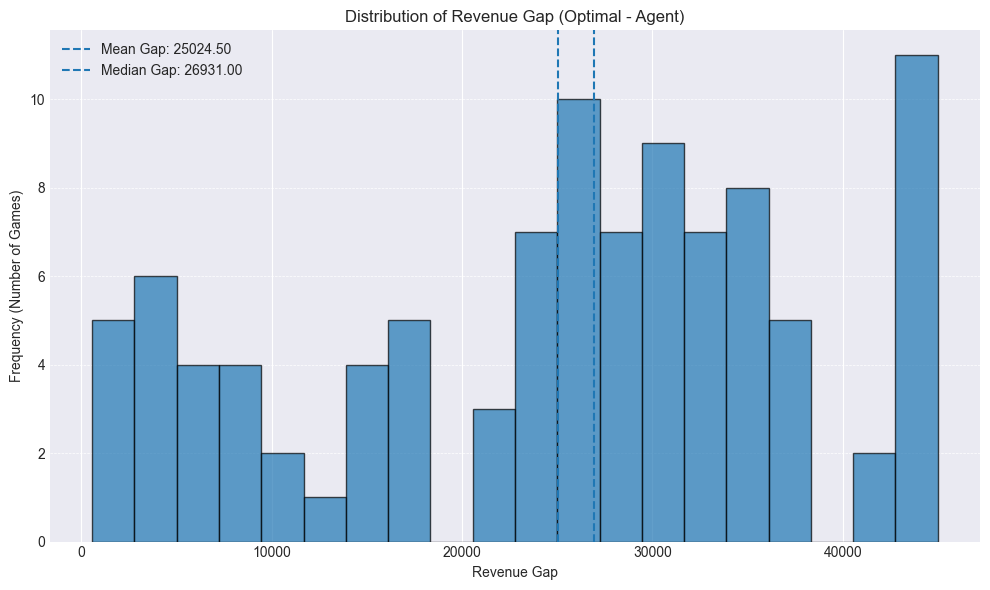

In [40]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv("rl_game_outcomes_1.csv")

# Ensure required columns exist
if 'optimal_revenue' not in df.columns or 'agent_revenue' not in df.columns:
    print("Error: The CSV must contain 'optimal_revenue' and 'agent_revenue' columns.")
else:
    # Calculate the revenue gap
    df['revenue_gap'] = df['optimal_revenue'] - df['agent_revenue']

    # Calculate main metrics for the revenue gap
    mean_gap = np.mean(df['revenue_gap'])
    std_dev_gap = np.std(df['revenue_gap'])
    min_gap = np.min(df['revenue_gap'])
    max_gap = np.max(df['revenue_gap'])
    median_gap = np.median(df['revenue_gap'])

    print("--- Revenue Gap Statistics ---")
    print(f"Mean Gap: {mean_gap:.2f}")
    print(f"Median Gap: {median_gap:.2f}")
    print(f"Standard Deviation of Gap: {std_dev_gap:.2f}")
    print(f"Minimum Gap: {min_gap:.2f}")
    print(f"Maximum Gap: {max_gap:.2f}")
    print(f"Number of Games Analyzed: {len(df)}")

    # Create the distribution plot (histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['revenue_gap'], bins=20, edgecolor='black', alpha=0.7)

    # Add lines for mean and median
    plt.axvline(mean_gap, linestyle='dashed', linewidth=1.5, label=f'Mean Gap: {mean_gap:.2f}')
    plt.axvline(median_gap, linestyle='dashed', linewidth=1.5, label=f'Median Gap: {median_gap:.2f}')

    # Titles and labels
    plt.title('Distribution of Revenue Gap (Optimal - Agent)')
    plt.xlabel('Revenue Gap')
    plt.ylabel('Frequency (Number of Games)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Improve layout and display
    plt.tight_layout()
    plt.show()




### Graph for lift_tier 2

--- Revenue Gap Statistics ---
Mean Gap: 23287.98
Median Gap: 23646.00
Standard Deviation of Gap: 11205.81
Minimum Gap: 732.00
Maximum Gap: 44976.00
Number of Games Analyzed: 100


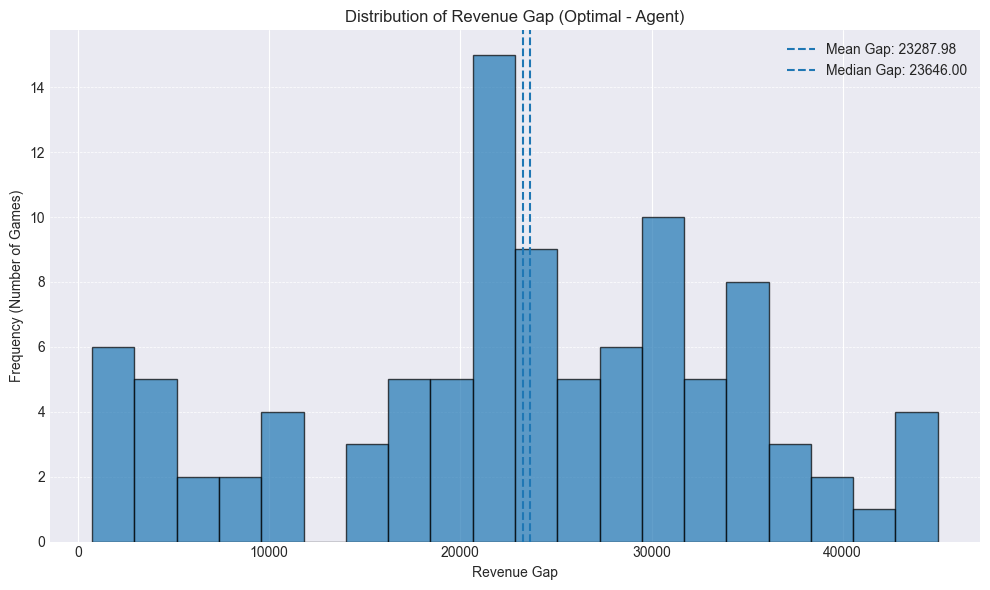

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv("rl_game_outcomes_2.csv")

# Ensure required columns exist
if 'optimal_revenue' not in df.columns or 'agent_revenue' not in df.columns:
    print("Error: The CSV must contain 'optimal_revenue' and 'agent_revenue' columns.")
else:
    # Calculate the revenue gap
    df['revenue_gap'] = df['optimal_revenue'] - df['agent_revenue']

    # Calculate main metrics for the revenue gap
    mean_gap = np.mean(df['revenue_gap'])
    std_dev_gap = np.std(df['revenue_gap'])
    min_gap = np.min(df['revenue_gap'])
    max_gap = np.max(df['revenue_gap'])
    median_gap = np.median(df['revenue_gap'])

    print("--- Revenue Gap Statistics ---")
    print(f"Mean Gap: {mean_gap:.2f}")
    print(f"Median Gap: {median_gap:.2f}")
    print(f"Standard Deviation of Gap: {std_dev_gap:.2f}")
    print(f"Minimum Gap: {min_gap:.2f}")
    print(f"Maximum Gap: {max_gap:.2f}")
    print(f"Number of Games Analyzed: {len(df)}")

    # Create the distribution plot (histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['revenue_gap'], bins=20, edgecolor='black', alpha=0.7)

    # Add lines for mean and median
    plt.axvline(mean_gap, linestyle='dashed', linewidth=1.5, label=f'Mean Gap: {mean_gap:.2f}')
    plt.axvline(median_gap, linestyle='dashed', linewidth=1.5, label=f'Median Gap: {median_gap:.2f}')

    # Titles and labels
    plt.title('Distribution of Revenue Gap (Optimal - Agent)')
    plt.xlabel('Revenue Gap')
    plt.ylabel('Frequency (Number of Games)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Improve layout and display
    plt.tight_layout()
    plt.show()

### Graph for lift_tier 3

--- Revenue Gap Statistics ---
Mean Gap: 22549.56
Median Gap: 24807.00
Standard Deviation of Gap: 12487.14
Minimum Gap: 0.00
Maximum Gap: 45000.00
Number of Games Analyzed: 100


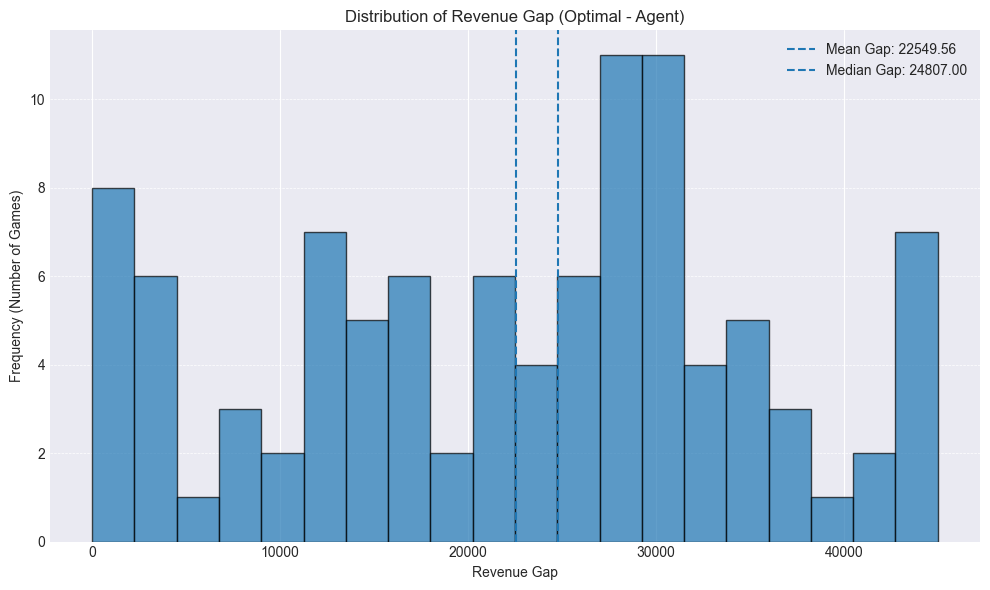

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv("rl_game_outcomes_3.csv")

# Ensure required columns exist
if 'optimal_revenue' not in df.columns or 'agent_revenue' not in df.columns:
    print("Error: The CSV must contain 'optimal_revenue' and 'agent_revenue' columns.")
else:
    # Calculate the revenue gap
    df['revenue_gap'] = df['optimal_revenue'] - df['agent_revenue']

    # Calculate main metrics for the revenue gap
    mean_gap = np.mean(df['revenue_gap'])
    std_dev_gap = np.std(df['revenue_gap'])
    min_gap = np.min(df['revenue_gap'])
    max_gap = np.max(df['revenue_gap'])
    median_gap = np.median(df['revenue_gap'])

    print("--- Revenue Gap Statistics ---")
    print(f"Mean Gap: {mean_gap:.2f}")
    print(f"Median Gap: {median_gap:.2f}")
    print(f"Standard Deviation of Gap: {std_dev_gap:.2f}")
    print(f"Minimum Gap: {min_gap:.2f}")
    print(f"Maximum Gap: {max_gap:.2f}")
    print(f"Number of Games Analyzed: {len(df)}")

    # Create the distribution plot (histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(df['revenue_gap'], bins=20, edgecolor='black', alpha=0.7)

    # Add lines for mean and median
    plt.axvline(mean_gap, linestyle='dashed', linewidth=1.5, label=f'Mean Gap: {mean_gap:.2f}')
    plt.axvline(median_gap, linestyle='dashed', linewidth=1.5, label=f'Median Gap: {median_gap:.2f}')

    # Titles and labels
    plt.title('Distribution of Revenue Gap (Optimal - Agent)')
    plt.xlabel('Revenue Gap')
    plt.ylabel('Frequency (Number of Games)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Improve layout and display
    plt.tight_layout()
    plt.show()